In [1]:
import argparse
import traceback
import time
import shutil
import logging
import yaml
import sys
import numpy as np
import copy
import os, glob, pickle
import cv2
from PIL import Image

import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.dpi'] = 200

# folderOne = "AutomotiveProperAlignment1"
# folderOne = "Every10SimultaneousMethod"
folderOne = "/media/ryan/New Volume/LiDARGenHideaway/DGXDataLiDARGenSettings/Densification/image_samples/images"
# folderOne = "AutomotiveAllForOne3"
# folderTwo = "AutomotiveFixedAttempt2"
# folderTwo = "AutomotiveAllForOneControlled4"
# folderTwo = "FortyNineTests"
folderTwo = ""
loadLocation = folderOne

In [27]:


allFiles = glob.glob(os.path.join(loadLocation, '*GT_image_grid_897.png'))
exampleFile = allFiles[0]
exampleFile = exampleFile.split('/')[-1]
allFileNums = []
allSettingNums = []
for tempFile in allFiles:
    tempFile = tempFile.split('/')[-1]
    plzSplit = tempFile.split('_')[0]
    plzSplit2 = tempFile.split('_')[1]
    allFileNums.append(int(plzSplit2))
    allSettingNums.append(int(plzSplit))
# largestFileNum = np.max(allFileNums)
# smallestFileNum = np.min(allFileNums)
largestFileNum = len(allFileNums)
smallestFileNum = 0
largestSettingNum = 1
smallestSettingNum = 0
print("argest is")
print(largestFileNum)
print(smallestFileNum)

batchNum = 42
actualBatchNum = 7
batchMod = batchNum // actualBatchNum
totalDistanceError = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalIntensityError = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalDistanceErrorInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalDistanceInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalIntensityErrorInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalPixels = np.zeros(actualBatchNum)
totalOriginDistances = np.zeros(actualBatchNum)

#For varying 
# full_list = glob.glob(os.path.join(loadLocation, '*GT_completion_897.pth.npy'))
# largestFileNum = len(full_list) - 1
# smallestFileNum = 0
time_list = glob.glob(os.path.join(loadLocation, '*0_*__TimeTaken.npy'))
timeArray = []
for time in time_list:
    timeArray.append(np.load(time).astype(float))
sortIndices = np.argsort(np.array(timeArray)).astype(int)
# print(sortIndices)
# print(sortIndices.shape)
# print(time_list.shape)
sortedList = np.array(time_list)[sortIndices]
# currentCount = -1
print("biggest")
print(largestFileNum)
print(smallestFileNum)
# totalTELEA_error = np.zeros(actualBatchNum)
totalNS_error = np.zeros(actualBatchNum)
# totalTELEA_error_intensity = np.zeros(actualBatchNum)
totalNS_error_intensity = np.zeros(actualBatchNum)
totalINTER_CUBIC_error = np.zeros(actualBatchNum)
totalINTER_NEAREST_error = np.zeros(actualBatchNum)
totalINTER_LINEAR_error = np.zeros(actualBatchNum)
totalINTER_CUBIC_error_intensity = np.zeros(actualBatchNum)
totalINTER_NEAREST_error_intensity = np.zeros(actualBatchNum)
totalINTER_LINEAR_error_intensity = np.zeros(actualBatchNum)
nearestStackDist = []
nearestStackInt = []
lidargenStackDist = []
gtStackDist = []
inputStackDist = []
for file_num in range(largestFileNum - smallestFileNum):
# for file_num in range(1):
    channelNum = 2 * batchNum
    file_num = file_num + smallestFileNum
    print("FILE NUM IS")
    print(file_num)
    # if(file_num != 4):
    #     continue
    file_name = sortedList[file_num]
    print(file_name)
    file_name = file_name.split('/')[-1][1:-15]
    print(file_name)
    if(os.path.isfile(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy') == False):
        print(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy')
        print("does note xist")
        continue
    GTPath = loadLocation + '/' + str(0) + file_name + '__GT_completion_897.pth.npy'
    InputPath = loadLocation + '/' + str(0)  + file_name + '__Input_completion_897.pth.npy'
    # GTPath = loadLocation + '/' + str(0) + '_' + str(file_num) + '_GT_completion_897.pth.npy'
    # InputPath = loadLocation + '/' + str(0)  + '_' + str(file_num) + '_Input_completion_897.pth.npy'
    GT = np.reshape(np.load(GTPath)[:,0],(channelNum,64,1024))
    # GT = np.where(GT > 1, 0, GT)
    # np.clip(GT,0.0001,1)
    Input = np.reshape(np.load(InputPath)[:,0],(channelNum,64,1024))
    # Input = np.where(Input >= 1, 0, Input)
    # np.clip(Input,0.0001,1)
    # print(np.sum(GT))
    # print(np.sum(Input))
    GTdistance = GT[:batchNum]
    loggedIgnore = 0.1
    # loggedIgnore = ((np.log2(loggedIgnore+1)) / 6)
    GTdistance = np.power(2,GTdistance*6)-1
    # GTdistance = np.clip(GTdistance,0.0001,2000)
    # GTdistance = np.where(GTdistance == 2000, 0.0001,GTdistance)
    mask = np.logical_and(Input[:batchNum] <= 0.001, GTdistance > loggedIgnore)
    # mask = GTdistance <= loggedIgnore
    # mask = Input[:batchNum] >= 0.001
    #If I just want to compare ALL points and... see what happens?
    mask = np.ones_like(mask)
    # mask[:,0:10] = 0
    # mask = np.logical_and(GTdistance > 0.5, GTdistance < 63)
    # mask = Input[:batchNum] <= 0.001
    # mask = base_mask
    # mask = np.logical_not(mask)
    inputMask = np.logical_and(Input[:batchNum] > 0.1, GTdistance < 63)
    print("MASK SHAPE")
    print(mask.shape)
    print("TRUE SAN CHECK")
    print(np.sum(Input[0][inputMask[0]] - GT[0][inputMask[0]]))
    print(np.sum(Input[0] == GT[0]))
    for multiplier in range(batchNum // actualBatchNum):
        for j in range(actualBatchNum):
            k = actualBatchNum*multiplier + j
            totalPixels[j] += np.sum(mask[k])
    GTintensity = GT[batchNum:]
    # print(GT.shape)
    # print(Input.shape)
    # GTdistance = np.where(mask,GTdistance,0)
    # GTintensity =np.where(mask,GTintensity,0)
    InputDist = np.float32(Input[:batchNum])
    InputIntensity = np.float32(Input[batchNum:])
    InputDist = np.power(2,InputDist*6)-1
    gtStackDist.append(GTdistance)
    # tempInputdistance = np.power(2,InputDist*6)-1
    tempInputdistance = InputDist
    inputStackDist.append(tempInputdistance)


    for multiplier in range(batchNum // actualBatchNum):
        for subSample in range(actualBatchNum):
                sample = actualBatchNum * multiplier + subSample
                fullSample = actualBatchNum * multiplier + subSample
                # DensificationMask = np.zeros_like(InputDist[sample])
                # DensificationMask[3::4] = 1
                # DensificationMask[1::4] = 1
                # DensificationMask[2::4] = 1
                DensificationMask = (InputDist[sample] <= loggedIgnore)
                NS_Result_temp = cv2.inpaint(InputDist[sample],DensificationMask.astype(np.uint8),3, flags=0)
                # TELEA_Result_temp = cv2.inpaint(InputDist[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=1)
                NS_Result_int = cv2.inpaint(InputIntensity[sample],DensificationMask.astype(np.uint8),3, flags=0)
                # TELEA_Result_int = cv2.inpaint(InputIntensity[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=1)

                print("SANITY CHECK TIME")
                print(GTdistance[fullSample][3::4].shape)

                # INTER_NEAREST_Result_temp = cv2.resize(InputDist[fullSample][3::4],(0, 0), (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                # INTER_NEAREST_Result_int = cv2.resize(InputIntensity[fullSample][3::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                # INTER_CUBIC_Result_temp = cv2.resize(InputDist[fullSample][3::4],(0, 0), (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
                # INTER_CUBIC_Result_int = cv2.resize(InputIntensity[fullSample][3::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
            
                INTER_NEAREST_Result_temp = cv2.resize(GTdistance[fullSample][0::4],(0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                INTER_NEAREST_Result_int = cv2.resize(GTintensity[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                INTER_CUBIC_Result_temp = cv2.resize(GTdistance[fullSample][0::4],(0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
                INTER_CUBIC_Result_int = cv2.resize(GTintensity[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
                 
                INTER_LINEAR_Result_temp = cv2.resize(GTdistance[fullSample][0::4],(0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_LINEAR)
                INTER_LINEAR_Result_int = cv2.resize(GTintensity[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_LINEAR)

                nearestStackDist.append(INTER_NEAREST_Result_temp)
                nearestStackInt.append(INTER_NEAREST_Result_int)
            
                # NS_Result_temp = np.clip(NS_Result_temp,0,1)
                # NS_Result_temp = np.power(2,NS_Result_temp*6)-1
                # NS_Result_int = np.clip(NS_Result_int,0,1)

                # INTER_NEAREST_Result_temp = np.clip(INTER_NEAREST_Result_temp,0.0001,2000)
                # INTER_NEAREST_Result_temp = np.power(2,INTER_NEAREST_Result_temp*6)-1
                # INTER_NEAREST_Result_int = np.clip(INTER_NEAREST_Result_int,0,1)

                # INTER_CUBIC_Result_temp = np.clip(INTER_CUBIC_Result_temp,0.0001,2000)
                # INTER_CUBIC_Result_temp = np.power(2,INTER_CUBIC_Result_temp*6)-1
                # INTER_CUBIC_Result_int = np.clip(INTER_CUBIC_Result_int,0,1)
                # TELEA_Result_temp = np.clip(TELEA_Result_temp,0,1)
                # TELEA_Result_int = np.clip(TELEA_Result_int,0,1)
                # TELEA_Result_temp = np.power(2,TELEA_Result_temp*6)-1
                # print("sanity check")
                # print(np.sum(InputIntensity[sample] > 1))
                # print(np.sum(TELEA_Result_int > 1))
                # print(np.sum(NS_Result_int > 1))
                # print(np.sum(GTintensity > 1))
                      
                
                # totalTELEA_error[subSample] += np.sum(np.absolute(TELEA_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalNS_error[subSample] += np.sum(np.absolute(NS_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                # totalTELEA_error_intensity[subSample] += np.sum(np.absolute(TELEA_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )
                totalNS_error_intensity[subSample] += np.sum(np.absolute(NS_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )

    
                totalINTER_CUBIC_error[subSample] += np.sum(np.absolute(INTER_CUBIC_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalINTER_CUBIC_error_intensity[subSample] += np.sum(np.absolute(INTER_CUBIC_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )
            
                totalINTER_NEAREST_error[subSample] += np.sum(np.absolute(INTER_NEAREST_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalINTER_NEAREST_error_intensity[subSample] += np.sum(np.absolute(INTER_NEAREST_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )
            
                totalINTER_LINEAR_error[subSample] += np.sum(np.absolute(INTER_LINEAR_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalINTER_LINEAR_error_intensity[subSample] += np.sum(np.absolute(INTER_LINEAR_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )

    #Get the distance between origins
    toWorld = np.squeeze(np.load(loadLocation + "/toWorld"+ file_name + "_.npy"))
    fromWorld = np.squeeze(np.load(loadLocation + "/fromWorld"+ file_name + "_.npy"))
    # toWorld = np.expand_dims(np.squeeze(np.load(loadLocation + "/toWorld"+ file_name + "_.npy")),0)
    # fromWorld = np.expand_dims(np.squeeze(np.load(loadLocation + "/fromWorld"+ file_name + "_.npy")),0)
    baseLine = np.array([0,0,0,1])
    origins = np.matmul(toWorld, baseLine)
    initialOrigin = np.matmul(np.linalg.inv(fromWorld), baseLine)
    print(np.absolute(origins - initialOrigin))
    origins = origins - initialOrigin
    origins = np.absolute(origins[:,:3])
    distances = np.sqrt(origins[:,0]*origins[:,0] + origins[:,1]*origins[:,1] + origins[:,2]*origins[:,2])
    # print("yessssssss")
    # print(distances)
    distances = np.reshape(distances, (batchNum//actualBatchNum, actualBatchNum))
    totalOriginDistances += np.sum(distances, 0)
    # print(totalOriginDistances)

    # for setting_num in range(1):
    for setting_num in range(largestSettingNum+1):
        loadNum = setting_num + smallestSettingNum
        maskedPath = loadLocation +'/' + str(loadNum) + file_name + '__Masked_completion_897.pth.npy'
        print(maskedPath)
        # numberOfOutputs = (setting_num + 2)
        numberOfOutputs = 1
        if(setting_num < 1):
            numberOfOutputs = actualBatchNum 
        actualChannelNum = numberOfOutputs*batchMod * 2
        # print("NUMBER OF FUCKING INPUTS")
        # print(numberOfInputs)
        # print(largestSettingNum)
        # print("setting")
        # print(setting_num)
        # mask = base_mask[:actualChannelNum]
        # inputMask = inputMask_base[:actualChannelNum]
        # sharedPath = loadLocation +'/' + str(setting_num) + '_' + str(file_num) + '_Masked_Shared_completion_897.pth.npy'
        prediction = np.reshape(np.load(maskedPath)[:,0],(actualChannelNum,64,1024))
        # prediction = np.where(prediction >= 1, 0, prediction)
        # prediction = np.clip(prediction,0,1)
        # prediction = np.where(prediction >= 2000, 0, prediction)
        # prediction = np.power(2,prediction*6)-1
        # print(np.mean(prediction[:batchNum][mask]))
        # print(np.mean(prediction))
        #no project back up
        distance = prediction[:actualChannelNum//2]
        # print(np.mean(distance))
        distance = np.power(2,distance*6)-1
        # distance = np.clip(distance,0.0001,2000)
        # distance =np.where(distance == 2000, 0.0001,distance)
        if(setting_num == 0):
            lidargenStackDist.append(distance)
        # print(np.mean(distance))
        intensity = prediction[actualChannelNum//2:]
        # print("mean is")
        # print(np.mean(distance[mask]))
        
        # distance = np.where(mask,distance,0)
        # intensity =np.where(mask,intensity,0)
        # print(np.mean(distance))
        for multiplier in range(batchNum // actualBatchNum):
            for subSample in range(numberOfOutputs):
                sample = numberOfOutputs * multiplier + subSample
                fullSample = actualBatchNum * multiplier + subSample
                # print(sample)
                distanceError = np.sum(np.absolute(distance[sample][mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )#/ GTdistance[sample][mask[sample]])
                intensityError = np.sum(np.absolute(intensity[sample][mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )#/ GTintensity[sample][mask[sample]])
                # distanceError = np.sum(np.absolute(distance[sample] - GTdistance[fullSample]) )#/ GTdistance[sample][mask[sample]])
                # intensityError = np.sum(np.absolute(intensity[sample] - GTintensity[fullSample]) )#/ GTintensity[sample][mask[sample]])
                distanceErrorInput = np.sum(np.absolute(distance[sample][inputMask[fullSample]] - GTdistance[fullSample][inputMask[fullSample]]) )#/ GTdistance[sample][mask[sample]])
                intensityErrorInput = np.sum(np.absolute(intensity[sample][inputMask[fullSample]] - GTintensity[fullSample][inputMask[fullSample]]) )#/ GTintensity[sample][mask[sample]])
                # print("before")
                print("ERROR")
                print(np.mean(distanceErrorInput))
                # print(totalDistanceErrorInput)
                if(subSample == 0):
                    print(sample)
                    print(distanceErrorInput)
                totalDistanceError[setting_num,subSample] += distanceError
                totalIntensityError[setting_num,subSample] += intensityError
                totalDistanceErrorInput[setting_num,subSample] += distanceErrorInput
                totalIntensityErrorInput[setting_num,subSample] += intensityErrorInput
                totalDistanceInput[setting_num,subSample] += np.sum(distance[sample][inputMask[fullSample]])
                # print(distanceErrorInput)
                # print("after")
                # print(totalDistanceErrorInput )

        # plt.imshow(mask[5])
        # plt.axis('off')
        # plt.show()
        # plt.imshow(np.absolute(GTdistance[5] - distance[5]))
        # plt.axis('off')
        # plt.show()
        # plt.imshow(distance[5])
        # plt.axis('off')
        # plt.show()

totalOriginDistances = totalOriginDistances / ((largestFileNum - smallestFileNum)*batchMod)
print(totalDistanceErrorInput)

argest is
13
0
biggest
13
0
FILE NUM IS
0
/media/ryan/New Volume/LiDARGenHideaway/DGXDataLiDARGenSettings/Densification/image_samples/images/1_6143_6183_3542_8510_3375_6935__TimeTaken.npy
_6143_6183_3542_8510_3375_6935
MASK SHAPE
(42, 64, 1024)
TRUE SAN CHECK
0.0
16384
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANIT

In [7]:
# distanceAcc = (totalTELEA_error) / (totalPixels+0.000001)
# intensityAcc = (totalTELEA_error_intensity) / (totalPixels+0.000001)
# print(distanceAcc)
# print(intensityAcc)
distanceAcc = (totalNS_error) / (totalPixels+0.000001)
intensityAcc = (totalNS_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

distanceAcc = (totalINTER_NEAREST_error) / (totalPixels+0.000001)
intensityAcc = (totalINTER_NEAREST_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

distanceAcc = (totalINTER_CUBIC_error) / (totalPixels+0.000001)
intensityAcc = (totalINTER_CUBIC_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

distanceAcc = (totalINTER_LINEAR_error) / (totalPixels+0.000001)
intensityAcc = (totalINTER_LINEAR_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

[ 3.34072599  5.25849179  6.06187525  6.40334398 20.77413539  9.69365467
 13.93425752]
[0.08657205 0.18296453 0.17971839 0.15047041 0.17545895 0.20694274
 0.19660973]
[2.14930401 2.24791267 2.25280144 2.33615585 2.131003   1.99357718
 2.48563414]
[0.09791941 0.07886928 0.07304067 0.07794606 0.0557749  0.05404231
 0.07761957]
[2.47319665 2.62879006 2.64531378 2.72413981 2.51559555 2.3445515
 2.95273137]
[0.10978013 0.09052718 0.08381575 0.08880947 0.06435163 0.06233752
 0.08988761]
[2.28995911 2.41770465 2.43137379 2.50750209 2.31089958 2.15425317
 2.7114019 ]
[0.1039932  0.08490919 0.07856704 0.08354529 0.05999365 0.05812284
 0.08398834]


In [24]:
totalInputPixels = np.zeros(actualBatchNum)
totalPixels = np.zeros(actualBatchNum)
for file_num in range(largestFileNum - smallestFileNum):
    channelNum = 2 * batchNum
    file_num = file_num + smallestFileNum
    print("FILE NUM IS")
    print(file_num)
    # if(file_num != 4):
    #     continue
    file_name = sortedList[file_num]
    print(file_name)
    file_name = file_name.split('/')[-1][1:-15]
    print(file_name)
    if(os.path.isfile(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy') == False):
        print(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy')
        print("does note xist")
        continue
    GTPath = loadLocation + '/' + str(0) + file_name + '__GT_completion_897.pth.npy'
    InputPath = loadLocation + '/' + str(0)  + file_name + '__Input_completion_897.pth.npy'
    # GTPath = loadLocation + '/' + str(0) + '_' + str(file_num) + '_GT_completion_897.pth.npy'
    # InputPath = loadLocation + '/' + str(0)  + '_' + str(file_num) + '_Input_completion_897.pth.npy'
    GT = np.reshape(np.load(GTPath)[:,0],(channelNum,64,1024))
    # GT = np.where(GT > 1, 0, GT)
    # np.clip(GT,0.0001,1)
    Input = np.reshape(np.load(InputPath)[:,0],(channelNum,64,1024))
    # Input = np.where(Input >= 1, 0, Input)
    # np.clip(Input,0.0001,1)
    # print(np.sum(GT))
    # print(np.sum(Input))
    GTdistance = GT[:batchNum]
    loggedIgnore = 0.1
    # loggedIgnore = ((np.log2(loggedIgnore+1)) / 6)
    GTdistance = np.power(2,GTdistance*6)-1
    # GTdistance = np.clip(GTdistance,0.0001,2000)
    # GTdistance = np.where(GTdistance == 2000, 0.0001,GTdistance)
    mask = np.logical_and(Input[:batchNum] <= 0.001, GTdistance > loggedIgnore)
    # mask = GTdistance <= loggedIgnore
    # mask = Input[:batchNum] >= 0.001
    #If I just want to compare ALL points and... see what happens?
    mask = np.ones_like(mask)
    # mask[:,0:10] = 0
    # mask = np.logical_and(GTdistance > 0.5, GTdistance < 63)
    # mask = Input[:batchNum] <= 0.001
    # mask = base_mask
    # mask = np.logical_not(mask)
    inputMask = np.logical_and(Input[:batchNum] > 0.1, GTdistance < 63)
    for multiplier in range(batchNum // actualBatchNum):
        for j in range(actualBatchNum):
            k = actualBatchNum*multiplier + j
            totalInputPixels[j] += np.sum(inputMask[k])
            totalPixels[j] += np.sum(mask[k])

FILE NUM IS
0
/media/ryan/New Volume/LiDARGenHideaway/DGXDataLiDARGenSettings/Densification/image_samples/images/1_6143_6183_3542_8510_3375_6935__TimeTaken.npy
_6143_6183_3542_8510_3375_6935
FILE NUM IS
1
/media/ryan/New Volume/LiDARGenHideaway/DGXDataLiDARGenSettings/Densification/image_samples/images/1_3547_11370_11253_3753_2863_7162__TimeTaken.npy
_3547_11370_11253_3753_2863_7162
FILE NUM IS
2
/media/ryan/New Volume/LiDARGenHideaway/DGXDataLiDARGenSettings/Densification/image_samples/images/1_738_1487_6677_780_10656_5028__TimeTaken.npy
_738_1487_6677_780_10656_5028
FILE NUM IS
3
/media/ryan/New Volume/LiDARGenHideaway/DGXDataLiDARGenSettings/Densification/image_samples/images/0_11424_886_9893_10593_808_3129__TimeTaken.npy
_11424_886_9893_10593_808_3129
FILE NUM IS
4
/media/ryan/New Volume/LiDARGenHideaway/DGXDataLiDARGenSettings/Densification/image_samples/images/1_7061_3683_2370_10372_6291_10828__TimeTaken.npy
_7061_3683_2370_10372_6291_10828
FILE NUM IS
5
/media/ryan/New Volume/Li

In [25]:
# print(totalPixels)
# print(64*1024*14*6)
print(totalPixels/((largestFileNum - smallestFileNum)*(batchMod)*64*1024))
print(totalInputPixels/((largestFileNum - smallestFileNum)*(batchMod)*64*1024))

[1. 1. 1. 1. 1. 1. 1.]
[0.55176896 0.20904795 0.17152307 0.22603627 0.09127612 0.12026625
 0.13712643]


In [28]:
print(totalPixels/((largestFileNum - smallestFileNum)*(batchMod)*64*1024))
# print(totalInputPixels/((largestFileNum - smallestFileNum+1)*(batchMod)*64*1024))
# print(totalOriginDistances)
print(totalPixels)
print("Za Input")
# print(largestFileNum)
print(totalDistanceErrorInput)
# totalInputPixels = ((largestFileNum - smallestFileNum+1)*64*1024)*(batchMod) - totalPixels
# print(totalDistanceInput / (totalInputPixels+0.000001))
# print(totalInputPixels/((largestFileNum - smallestFileNum+1)*(batchMod)*64*1024))

# totalDistanceError = np.square(totalDistanceError)
for setting_num in range(largestSettingNum - smallestSettingNum+1):
    loadNum = setting_num + smallestSettingNum
    # distanceAcc = np.sum((totalDistanceError[setting_num])) / np.sum(totalPixels)
    # intensityAcc = np.sum((totalIntensityError[setting_num])) / np.sum(totalPixels)
    # distanceAcc = np.sum((totalDistanceError[setting_num][1:])) / np.sum(totalPixels[1:])
    # intensityAcc = np.sum((totalIntensityError[setting_num][1:])) / np.sum(totalPixels[1:])
    # distanceAcc = (totalDistanceError[setting_num][1:]) / totalPixels[1:]
    # intensityAcc = (totalIntensityError[setting_num][1:]) / totalPixels[1:]
    distanceAcc = (totalDistanceError[setting_num]) / (totalPixels+0.000001)
    intensityAcc = (totalIntensityError[setting_num]) / (totalPixels+0.000001)
    # distanceAcc = (totalDistanceError[setting_num][0]) / totalPixels[0]
    # intensityAcc = (totalIntensityError[setting_num][0]) / totalPixels[0]
    # distanceAcc = (totalDistanceError[setting_num][4]) / totalPixels[4]
    # intensityAcc = (totalIntensityError[setting_num][4]) / totalPixels[4]
    
    # distanceAccInput = (totalDistanceErrorInput[setting_num]) / (totalInputPixels+0.000001)
    # intensityAccInput = (totalIntensityErrorInput[setting_num]) / (totalInputPixels+0.000001)
    print("Setting: " + str(loadNum) + " Distance is: " + str(distanceAcc) + " Intensity is : " + str(intensityAcc))
    # if(setting_num == largestSettingNum - smallestSettingNum ):
    # print("Input: " + str(loadNum) + " Distance is: " + str(distanceAccInput) + " Intensity is : " + str(intensityAccInput))
print("comparing the pair")
# improvement = (totalDistanceError[0][1:] - totalDistanceError[1][1:]) / totalDistanceError[0][1:] 
# print(improvement)
# if(folderTwo != ""):
#     for setting_num in range(largestSettingNum2 - smallestSettingNum2+1):
#         loadNum = setting_num + smallestSettingNum2
#         # distanceAcc = np.sum((totalDistanceError2[setting_num])) / np.sum(totalPixels2)
#         # intensityAcc = np.sum((totalIntensityError2[setting_num])) / np.sum(totalPixels2)
#         # distanceAcc = np.sum((totalDistanceError[setting_num][1:])) / np.sum(totalPixels[1:])
#         # intensityAcc = np.sum((totalIntensityError[setting_num][1:])) / np.sum(totalPixels[1:])
#         # distanceAcc = (totalDistanceError[setting_num][1:]) / totalPixels[1:]
#         # intensityAcc = (totalIntensityError[setting_num][1:]) / totalPixels[1:]
#         distanceAcc = (totalDistanceError[setting_num]) / totalPixels
#         intensityAcc = (totalIntensityError[setting_num]) / totalPixels
#         # distanceAcc = (totalDistanceError2[setting_num][5:]) / totalPixels2[5:]
#         # intensityAcc = (totalIntensityError2[setting_num][5:]) / totalPixels2[5:]
#         # distanceAcc = (totalDistanceError[setting_num][4]) / totalPixels[4]
#         # intensityAcc = (totalIntensityError[setting_num][4]) / totalPixels[4]
#         print("Setting: " + str(loadNum) + " Distance is: " + str(distanceAcc) + " Intensity is : " + str(intensityAcc))

# print("comparing the pair")
# # improvement = (totalDistanceError[0][5:] - totalDistanceError[1][5:]) / totalDistanceError[0][5:] 
# print(improvement)

[1. 1. 1. 1. 1. 1. 1.]
[5111808. 5111808. 5111808. 5111808. 5111808. 5111808. 5111808.]
Za Input
[[8.90563383e-01 2.99088873e+05 2.98714677e+05 2.73793266e+05
  4.02396321e+05 4.29836338e+05 2.41480954e+05]
 [8.90563383e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Setting: 0 Distance is: [2.36666649 4.9762036  4.973671   4.70573496 5.82892116 5.81046388
 5.55921563] Intensity is : [0.07717341 0.19339107 0.18870157 0.17909902 0.20867019 0.20982006
 0.1937778 ]
Setting: 1 Distance is: [1.57923575 0.         0.         0.         0.         0.
 0.        ] Intensity is : [0.0812673 0.        0.        0.        0.        0.        0.       ]
comparing the pair


original


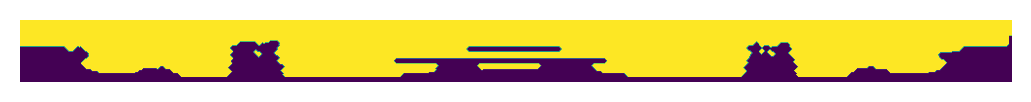

(64, 1024, 3)


In [10]:
existVals = np.load("existTotalLiDARGenSettings.npy")
import scipy
from PIL import Image

import matplotlib.pyplot as plt
existVals = existVals > np.max(existVals) / 3
existVals[2:] = scipy.ndimage.binary_erosion(existVals[2:], border_value = 1, iterations=4)
existVals[:15] = scipy.ndimage.binary_closing(existVals[:15], border_value = 1, iterations=3)
existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)
existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)

%matplotlib inline

plt.rcParams['figure.dpi'] = 200
print("original")

plt.imshow(existVals)
plt.axis('off')
plt.show()

im = Image.fromarray(existVals)
im = im.convert('RGB')
arr = np.array(im)
print(arr.shape)
arr[:,:,0] = 0
im = Image.fromarray(arr)
im.save("maskThird.png")

In [17]:
gtImage = np.load("DGXDataLiDARGenSettings/Line/GroundTruth/0_738_1487_6677_780_10656_5028__GT_completion_897.pth.npy")
print(gtImage.shape)
gtImage = gtImage[0,0,:,:]
print(np.max(gtImage))
print(np.min(gtImage))
gtImage = np.uint8(gtImage * 255)
print(np.max(gtImage))
print(np.min(gtImage))
im = Image.fromarray(gtImage,'L')
im.save("gtImageExample.png")

(84, 3, 64, 1024)
1.0
2.404371518242305e-05
255
0


['QuickTestOfLiDARGenSettingsDensification/0_4743__TimeTaken.npy'
 'QuickTestOfLiDARGenSettingsDensification/0_5436__TimeTaken.npy'
 'QuickTestOfLiDARGenSettingsDensification/0_6196__TimeTaken.npy'
 'QuickTestOfLiDARGenSettingsDensification/0_7538__TimeTaken.npy']
QuickTestOfLiDARGenSettingsDensification/0_7538__TimeTaken.npy


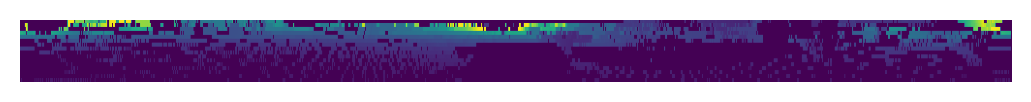

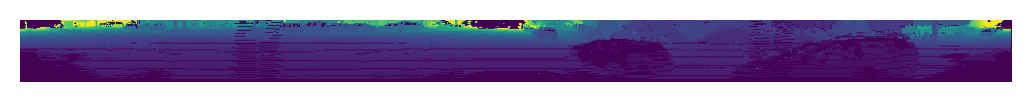

IS same?
590573.0989168526
1296.0056618426847
9.011430342359201
9.999999999998899e-05
[1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
FUUUUUCK YUUUU
232.94624035796767
7.509239731091524
8.049174169554426
[8.45712987 8.42713332 8.34714192 8.32914324 8.34114219 8.34714138
 8.35514037 8.27314919 8.26314997 8.33514282 8.33314245 8.30114618
 8.30914589 8.19715706 8.19115832 8.12316607 8.05917305 8.055173
 8.11716607 8.10716705 8.02717628 8.04917417 8.02717627 8.011178
 7.97718203 7.94518581 7.94118598 7.92318877 7.91119019 7.86719515
 7.84319843 7.82520015 7.81320176 7.78920422 7.75920847 7.74321023
 7.7252129  7.72121273 7.68921692 7.67321958]


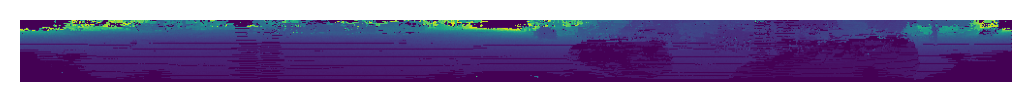

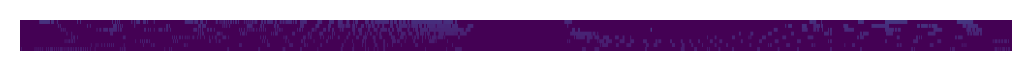

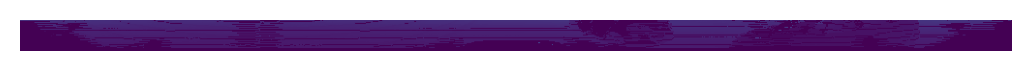

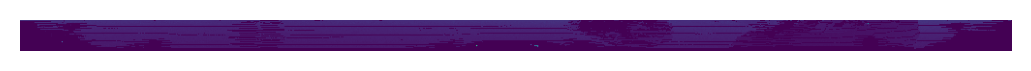

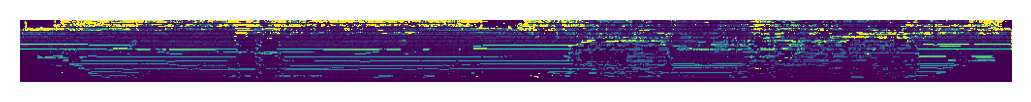

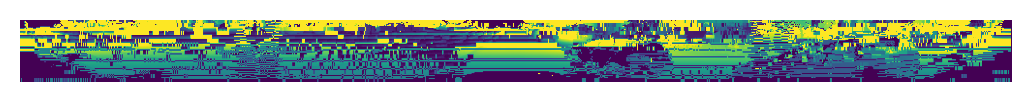

0.0
8.823385269034217
8.757603
146788.8542561417
390434.3574985285


In [18]:
max = 64
min = 0
fileNumToUse = -1
print(sortedList)
print(sortedList[fileNumToUse])
number = sortedList[fileNumToUse].split('/')[-1].split('_')[1]
# print(fuckMeList[int(number)])
plt.imshow(nearestStackDist[fileNumToUse],vmin=min,vmax=max)
plt.axis('off')
plt.show()

plt.imshow(gtStackDist[fileNumToUse][0],vmin=min,vmax=max)
plt.axis('off')
plt.show()

print("IS same?")
print(np.sum(gtStackDist[fileNumToUse][0]))
print(np.sum(gtStackDist[fileNumToUse][0][30,:300]))
print(np.mean(gtStackDist[fileNumToUse][0]))
print(np.min(gtStackDist[fileNumToUse][0]))
print((gtStackDist[fileNumToUse][0][30,:10]))

print("FUUUUUCK YUUUU")
print(np.sum(gtStackDist[fileNumToUse][0][30,180:210]))
print(np.min(gtStackDist[fileNumToUse][0][30,180:210]))
print(np.max(gtStackDist[fileNumToUse][0][30,180:210]))
print(gtStackDist[fileNumToUse][0][30,160:200])

# plt.imshow(gtStackDist[fileNumToUse][0][30:32],vmin=min,vmax=max)
# plt.axis('off')
# plt.show()

plt.imshow(lidargenStackDist[fileNumToUse][0],vmin=min,vmax=max)
plt.axis('off')
plt.show()

plt.imshow(nearestStackDist[fileNumToUse][32:],vmin=min,vmax=max)# - gtStackDist[0][0][32:])
plt.axis('off')
plt.show()

plt.imshow(gtStackDist[fileNumToUse][0][32:],vmin=min,vmax=max)
plt.axis('off')
plt.show()

plt.imshow(lidargenStackDist[fileNumToUse][0][32:],vmin=min,vmax=max)#) - gtStackDist[0][0][32:])
plt.axis('off')
plt.show()

plt.imshow(np.absolute(lidargenStackDist[fileNumToUse][0] - gtStackDist[fileNumToUse][0]),vmin=min,vmax=10)
plt.axis('off')
plt.show()

plt.imshow(np.absolute(nearestStackDist[fileNumToUse] - gtStackDist[fileNumToUse][0]),vmin=min,vmax=10)
plt.axis('off')
plt.show()

print(np.mean(inputStackDist[fileNumToUse][0][3::4]))
print(np.mean(gtStackDist[fileNumToUse][0][3::4]))
print(np.mean(lidargenStackDist[fileNumToUse][0][3::4]))

print(np.sum(np.absolute(lidargenStackDist[fileNumToUse][0] - gtStackDist[fileNumToUse][0])))
print(np.sum(np.absolute(nearestStackDist[fileNumToUse] - gtStackDist[fileNumToUse][0])))